# Facial Emotion Recognition using Deep Learning

### Step 1: Import Required Libraries

#### Why?
##### We need essential libraries for loading, processing images, and building our deep learning model.

In [ ]:
# Install required packages
!pip install -q tensorflow

# Import necessary libraries
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Kagglehub Python library to download a dataset from Kaggle directly into the environment.
 
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fer2013


### Step 2: Define Paths and Image Parameters

#### Why?
##### Setting up folder paths and image size helps in feeding consistent input into the neural network.

In [ ]:
# Define dataset directory paths
dataset_path = "/kaggle/input/fer2013"
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")

### Step 3: Load and Preprocess Images Using ImageDataGenerator

#### Why?
##### We use ImageDataGenerator to normalize pixel values (scale 0–255 to 0–1) and to optionally augment training images to reduce overfitting.

In [ ]:
# Define Data Augmentation with mild transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators without 'workers' (Handled by Keras automatically)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical"
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Compute class weights to handle imbalanced dataset
train_classes = np.array(train_generator.classes)
class_labels = np.unique(train_classes)
class_weights = compute_class_weight('balanced', classes=class_labels, y=train_classes)
class_weights = np.clip(class_weights, 0.5, 2.0)  # Lower max cap to 2.0 to prevent extreme bias
class_weights_dict = dict(enumerate(class_weights))

print("Final Class Weights:", class_weights_dict)

Final Class Weights: {0: np.float64(1.0266046844269623), 1: np.float64(2.0), 2: np.float64(1.0010460615781582), 3: np.float64(0.5684387684387684), 4: np.float64(0.8260394187886635), 5: np.float64(0.8491274770777877), 6: np.float64(1.293372978330405)}


### Step 4: Build a CNN Model

#### Why?
##### CNNs are great for learning patterns in images like edges, shapes, and facial features.

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D

# Define an improved CNN architecture
model = Sequential([
    Input(shape=(48,48,1)),

    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(pool_size=(2,2)),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.5),
    Dense(7, activation='softmax') # 7 Emotion Classes
])

### Step 5: Compile the Model

#### Why?
##### Compiling sets up the model to be trained. We define the optimizer, loss function, and evaluation metric.

In [ ]:
# Define optimizer with weight decay
optimizer = AdamW(learning_rate=3e-4, weight_decay=1e-5)

# Compile model with label smoothing
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=optimizer,
    metrics=["accuracy"]
)

# Show model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281,223 (4.89 MB)

 Trainable params: 1,280,327 (4.88 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

### Step 6: Train the Model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 173s 361ms/step - accuracy: 0.2059 - loss: 1.8145 - val_accuracy: 0.1783 - val_loss: 2.0176 - learning_rate: 3.0000e-04
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 44s 99ms/step - accuracy: 0.3455 - loss: 1.6269 - val_accuracy: 0.4433 - val_loss: 1.6796 - learning_rate: 3.0000e-04
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 81s 98ms/step - accuracy: 0.4742 - loss: 1.4659 - val_accuracy: 0.4745 - val_loss: 1.6209 - learning_rate: 3.0000e-04
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - accuracy: 0.5296 - loss: 1.3755 - val_accuracy: 0.4858 - val_loss: 1.6079 - learning_rate: 3.0000e-04
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - accuracy: 0.5443 - loss: 1.3413 - val_accuracy: 0.4993 - val_loss: 1.5133 - learning_rate: 3.0000e-04
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - accuracy: 0.5632 - loss: 1.3209 - val_accuracy: 0.4149 - val_loss: 1.7230 - learning_rate: 3.0000e-04
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/

### Step 7: Evaluate and Plot Performance

#### Why?
##### To understand how well the model is learning and if there’s overfitting.

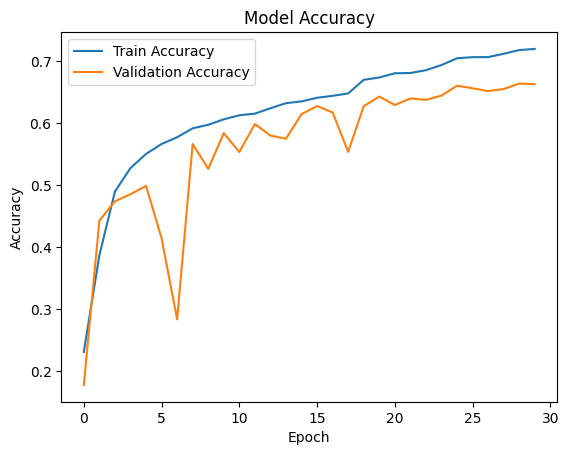

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

### Step 8: Save the Model

In [ ]:
model.save('emotion_model.h5')